### Introduction
Coming soon ...

In [364]:
# Import modules and packages
import copy
from pomegranate import *
import matplotlib
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc, roc_auc_score,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support, precision_score, accuracy_score, matthews_corrcoef)

In [255]:
def read_model_from_json(filename=None, verbose=False):
    """
    Reads and returns model data from JSON file.
    
    Parameters
    ----------
    filename : str
               Path to a saved model in JSON format
    verbose  : bool, optional, default False
               When True, prints progress to STDOUT
    
    Returns
    ----------
    dict
    JSON data as dictionary
    """
    
    with open(filename, 'r') as f:
        modeldata = json.load(f)
        #print(modeldata['edges'][2])
        if verbose: print("Model read from:", filename)
        return(modeldata)



def train_hmm(distribution=None, n_components=None, state_names=None, X=None, labels=None, algorithm=None, n_jobs=None):
    """
    Helper function to train and bake Pomogranate HMM model. Returns baked Pomogranate HMM model.
    Make sure you import the pomogranate package as-
    from pomegranate import *
    
    This function uses (docstrings are appended below)-
    pomogranate.HiddenMarkovModel.from_samples
    pomogranate.HiddenMarkovModel.bake
    
    """
    
    """
    # Example:
    model = HiddenMarkovModel.from_samples(distribution=DiscreteDistribution, n_components=2,
                                         state_names=['F','T'],
                                         X=train_seqs, labels=train_labels,
                                         algorithm='labeled',
                                         n_jobs=2)
    """
    
    model = HiddenMarkovModel.from_samples(distribution=distribution, n_components=n_components,
                                         state_names=state_names,
                                         X=X, labels=labels,
                                         algorithm=algorithm,
                                         n_jobs=n_jobs)
    model.bake()
    return(model)
# Append docstring
train_hmm.__doc__ += "\nHiddenMarkovModel.from_samples\n\n" + HiddenMarkovModel.from_samples.__doc__
train_hmm.__doc__ += "\n\nHiddenMarkovModel.bake\n\n" + HiddenMarkovModel.bake.__doc__


In [341]:
def validate(model=None, states=None, true_seqs=None, true_labels=None, verbose=False):
    """
    Validates true sequences and labels using a given model.
    Designed only for two state models. Thus the states must be two in number.
    The first state in the 'states' list is considered 0 and the second state is considered 1. 
    Calculates and returns validation metrics (see below).
    
    Parameters
    ----------
    model            : Pomogranate HMM model object, default None
    states           : list, default None
                       List of states (str) used in the sequences. Must be two in number.
                       The function is designed only for two state models.
                       The first state in the 'states' list is considered 0 and the second state 
                       is considered 1.
    true_seqs        : Pandas data series, default None
                       Values are sequences (strings) of characters for which labels are to be 
                       predicted using the model.
    true_labels      : Pandas data series, default None
                       Values are sequences (strings) of characters representing labels or states
                       that will be used to compare with the predicted labels or states.
    verbose          : bool, optional, default False
                       When True, prints information to STDOUT

    
    Returns
    ----------
    dict
    Dictionary model validation metrics-
    ConfusionMatrix, Recall, Precision, Accuracy, MCC, AUC and F1score
    """
    
    # Confirm that number of states are two
    try:
        assert(len(states)==2)
    except AssertionError:
        print("Error: Number states is not equal to 2.")
        return({"ConfusionMatrix":None,"Recall":None,"Precision":None,"Accuracy":None,"MCC":None,"AUC":None,"F1score":None})

    y_true_all = []
    y_pred_all = []
    F_predictedAs_T_fraction = []
    T_predictedAs_F_fraction = []
    recall = []
    precision = []
    accuracy = []
    f1 = []
    for i in true_seqs.index:
        y_true = [int(ch==states[1]) for ch in true_labels[i]] # inserts 0 for first state and 1 for second state
        y_true_all += copy.copy(y_true)
        y_pred = model.predict(list(true_seqs[i]))
        y_pred_all += copy.copy(y_pred)
        #print([int(ch=='T') for ch in true_labels[i]])
        #print("".join([states[i] for i in pred_labels]))
        #print(pred_labels)
        #print(i,"\n",true_seqs[i],"\n",true_labels[i],"\n","".join([states[i] for i in y_pred]))
    
    """
    print(len(y_true_all),len(y_pred_all))
    print()
    print("Confusion Matrix:")
    print(confusion_matrix(y_true_all,y_pred_all))
    print("Recall:",recall_score(y_true_all,y_pred_all))
    print("Precision:",precision_score(y_true_all,y_pred_all))
    print("Accuracy:",accuracy_score(y_true_all,y_pred_all))
    print("MCC:",matthews_corrcoef(y_true_all,y_pred_all))
    print("AUC:",roc_auc_score(y_true_all,y_pred_all))
    print("F1 score:",f1_score(y_true_all,y_pred_all))
    """
    return {"ConfusionMatrix":confusion_matrix(y_true_all,y_pred_all),
                    "Recall":recall_score(y_true_all,y_pred_all),
                    "Precision":precision_score(y_true_all,y_pred_all),
                    "Accuracy":accuracy_score(y_true_all,y_pred_all),
                    "MCC":matthews_corrcoef(y_true_all,y_pred_all),
                    "AUC":roc_auc_score(y_true_all,y_pred_all),
                    "F1score":f1_score(y_true_all,y_pred_all)}

In [257]:
# Temporary functions
def histogram1d(data=None, binsize=None, xmin=None, xmax=None):
    if xmin is None and xmax is None:
        xmin = min(data)
        xmax = max(data)
    xedges = np.arange(xmin,xmax+binsize,binsize)
    H, xe = np.histogram(data,bins=xedges)
    #print("Value range:",xmin,xmax)
    return(H,xe)

In [263]:
def translate(seq=None,translation_dict=None):
    """
    Translates sequence of characters based on the provided translation dictionary.
    
    Parameters
    ----------
    seq              : str, default None
                       Sequence of characters to be translated
    translation_dict : dict, default None
                       Dictionary to use for translation of 'seq'.
                       All characters in the input sequence must be present in the keys of the translation dictionary.
    
    Returns
    ----------
    str
    Translated sequence
    
    """
    if translation_dict:
        return("".join([translation_dict[ch] for ch in seq]))
    else:
        return("".join([ch for ch in seq]))

    
def get_seq_dictionary(datadir=None, filelist=None, header_regex_str=None, translation_dict=None, verbose=False):
    """
    Translates sequence of characters based on the provided translation dictionary.
    
    Parameters
    ----------
    datadir          : str, default None
                       Path to directory that contains files containing sequences in FASTA format (shown below).
                       > sequence name 1
                       ALKDSFJOSDIFUSDCOSDNWEIFUCSNDJ
                       > sequence name 2
                       OSIFJODSICVJIWDCNSIDCIWF
                       > sequence name 3
                       LAKSDJFOWIEROSICJOISFJLSKDFD
    filelist         : list, default None
                       List of file names (str) to read from 'datadir'
    header_regex_str : str, default None
                       The header is parsed according to this regex string and first match group is used at the key.
                       If None then the full header line (except the last new line) is used as the key.
    translation_dict : dict, default None
                       Dictionary to use for translation of 'seq'.
                       All characters in the input sequence must be present in the keys of the translation dictionary.
    verbose          : bool, optional, default False
                       When True, prints information to STDOUT

    
    Returns
    ----------
    dict
    Dictionary of sequences.
    Keys are sequence headers read from FASTA formatted sequences.
    Values are sequences translated using 'traslation_dict'.
    If a duplicate sequence header is found then it is replaced by the one found later.
    
    """
    
    if header_regex_str is None:
        header_regex_str = '(.*)\n'

    seq = {}
    for filename in filelist:
        try:
            f = open(datadir+"/"+filename,'r')
        except:
            if verbose:
                print("Error while opening file", datadir+"/"+filename)
            continue

        for line in f.readlines():
            if line.startswith('>'):
                matchObj = re.match(header_regex_str,line,re.S)
                header = matchObj.group(1)
                seq[header] = ""
            else:
                seq[header] += translate(line.replace('\n',''),translation_dict=translation_dict)
        f.close()
    return(seq)


<h3>Define input variables</h3>

In [258]:
### Data directory
datadir = "pakTailSeqs"

In [259]:
### List of tail and full length sequence files

tail_seq_files = [
#'adk_cdhit90_tails.fasta',
#'hbha_cdhit90_tails.fasta',
#'hc1_cdhit90_tails.fasta',
#'hc2_cdhit90_tails.fasta',
'hu_cdhit90_tails.fasta'
#'ku_cdhit90_tails.fasta'
#'l22_cdhit90_tails.fasta',
#'rbr_cdhit90_tails.fasta'#? Manually identified tails are probably not correct PAK tails.
#'sig_cdhit90_tails.fasta'#? Manually identified tails are probably not correct PAK tails.
#'tig_cdhit90_tails.fasta',
#'topo1_cdhit90_tails.fasta',
#'topo3_cdhit90_tails.fasta'
]

full_seq_files = [
#'adk_cdhit90.fasta',
#'hbha_cdhit90.fasta',
#'hc1_cdhit90.fasta',
#'hc2_cdhit90.fasta',
'hu_cdhit90.fasta'
#'ku_cdhit90.fasta'
#'l22_cdhit90.fasta',
#'rbr_cdhit90.fasta'#? Manually identified tails are probably not correct PAK tails.
#'sig_cdhit90.fasta'#? Manually identified tails are probably not correct PAK tails.
#'tig_cdhit90.fasta',
#'topo1_cdhit90.fasta',
#'topo3_cdhit90.fasta'
]

### Define observed states

In [260]:
# Define observed states for HMM
#
# Amino acid residue codes (i.e. observed states)
# Amino acids P, A, K and T are most common in manually identified PAK-tails in HU proteins.
# Below are the frequencies.
# A 0.329
# K 0.264
# T 0.184
# P 0.067
# Proline is distinctly infrequent compared to A, K and T,
# but PAK-tail analysis described by Khare et al* indicates its importance in the dynamics and conformation of the tails.
# Hence Proline is considered as a separate category.
#
# Categories: This categorization will help in discriminating P, A, K, T and other amino acids (O).
# Taking P, A, K and T in one group leads to poly-A or poly-P stretches to be labeled as PAK-tails.
# Keeping P, A, K and T as separate categories might help in learning their combinations.
# Categories are assigned as follows.
# P
# A
# K
# T
# O: OTHERS (D,E,G,A,V,L,I,M,C,N,Q,F,Y,W,P,S,T)
#
# *Conformational heterogeneity in tails of DNA-binding proteins is augmented by proline containing repeats; Khare et al 2017

# Amino acid code single letter
aa_code1 = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','X','Y']

# Amino acid categories i.e. the observed states for HMM
aa_code_cat = ['P','A','K','T','O']

# Amino acid category mapping dictionary
aa_code_cat_dict = {'P':'P',
                     'A':'A',
                     'K':'K',
                     'T':'T',
                     'C':'O', 'D':'O', 'E':'O', 'F':'O', 'G':'O', 'H':'O', 'I':'O', 'L':'O',
                     'M':'O', 'N':'O', 'Q':'O', 'R':'O', 'S':'O', 'V':'O', 'W':'O', 'X':'O', 'Y':'O'}

### Define hidden states

In [261]:
### Define hidden states for HMM. Two states here, Folded and Tail.
states = ['F','T']

In [262]:
# Number of hidden states for HMM
n_states = len(states)

# Numger of observed staets for HMM
n_states_observed = len(aa_code_cat)

<h3>Prepare input data</h3>

In [264]:
seq_tail = get_seq_dictionary(datadir=datadir, filelist=tail_seq_files, header_regex_str='>(.+).*\n', translation_dict=aa_code_cat_dict, verbose=True)
seq_full = get_seq_dictionary(datadir=datadir, filelist=full_seq_files, header_regex_str='>(.+?)\s.*\n', translation_dict=aa_code_cat_dict, verbose=True)

print("Number of tail sequences:",len(seq_tail),"\nNumber of all (full) sequences:",len(seq_full))

Number of tail sequences: 59 
Number of all (full) sequences: 1353


In [268]:
### Convert data into Pandas objects
tail = pd.Series(seq_tail)
full = pd.Series(seq_full)
print("Tail seqs:",tail.shape,"\nFull seqs:",full.shape)
print(tail.head())
#print(full.head())

Tail seqs: (59,) 
Full seqs: (1353,)
tr|A0A0T9L3R4|A0A0T9L3R4_MYCTX    AOOAPAOOOOPAAOPOAAOTOAOOPOAPAAKKAKOAKOOKOOKOOK...
tr|A0A077M8Y5|A0A077M8Y5_9MICO    AOPOKOPKTAOTOOOAPAOOATATATKAAAKKTTTAKOTTAAKKTT...
tr|W7SIK7|W7SIK7_9PSEU            OOTOKOPOOTAAAAKPAAOPAAKATAKOOATKPAOOATAAKATATO...
tr|H0K1H8|H0K1H8_9PSEU            OOAKKOPKATTTKOOTTOTOOTTAOTAKTAATOPTOTOOTTOOTOA...
tr|A0A0H5CLV3|A0A0H5CLV3_9PSEU    OOTKKOPKOAATOPAAAAPAAOATATOTTATOATTATOTTOAAAOT...
dtype: object


In [269]:
### Make dataframe containing tails and full length sequences
### Create columns containing label sequences
df = pd.concat([full, tail], axis=1, sort=True)

df.columns=['FULL','TAIL']
df = df.replace(np.nan, '', regex=True)
df['FULLLEN'] = df['FULL'].str.len()
df['TAILLEN'] = df['TAIL'].str.len()
df['FOLDLEN'] = df['FULLLEN'] - df['TAILLEN']
#df['FoldLabels'] = df['FoldLen'].apply(lambda x: 'F'*x)
#df['TailLabels'] = df['TailLen'].apply(lambda x: 'T'*x)
df['FULLLABELS'] = df['FOLDLEN'].apply(lambda x: 'F'*x) + df['TAILLEN'].apply(lambda x: 'T'*x)
#df['Tally'] = df['FullLabels'].str.len()
#df.to_csv(path_or_buf="test.csv",sep=",")

df['HEADER'] = df.index
df.reset_index(drop=True, inplace=True)

print("Columns:",df.columns)
print("Shape (all seqs):",df.shape)
#print(df[df['Tail'] != ''].head())
print("Shape (tail seqs):",df[df['TAIL'] != ''].shape)
df.head()
#df.index

Columns: Index(['FULL', 'TAIL', 'FULLLEN', 'TAILLEN', 'FOLDLEN', 'FULLLABELS',
       'HEADER'],
      dtype='object')
Shape (all seqs): (1353, 7)
Shape (tail seqs): (59, 7)


,FULL,TAIL,FULLLEN,TAILLEN,FOLDLEN,FULLLABELS,HEADER
0,OOKAOOOOOOTOKOOOOOOOATAAOOOOOOTOOOAOOKOOOOTOTO...,AOAOOOPOOOPAOKOOOATOAAKKAAOKKAPOKKAOAKKAATKAPA...,200,111,89,FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF...,sp|O33125|DBH_MYCLE
1,OOKOOOOOAOAOKAOOTKOOAAOAOOAOOOOOOAOOKOKOOOOOAO...,,91,0,91,FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF...,sp|P02348|DBH5_RHILE
2,OOKOOOOOAOAAOAOOPKAOAOOAOOAOOOOOTOAOKAOOOOOOOO...,,90,0,90,FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF...,sp|P05384|DBHB_PSEAE
3,OOKOOOOOKOAAOAOOOKAAAOOAOOAOOAOOTOOOKOOOOOAOOO...,,90,0,90,FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF...,sp|P0A1R8|DBHB_SALTY
4,OTKKOOOOOOAKKAOAKKKOOKOOOOTOOOTOTOAOAKOOKOOOOO...,,90,0,90,FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF...,sp|P36206|DBH_THEMA


In [270]:
### Split input data into train and test sets

### Standard way of train test splitting:
### X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
### We consider amino acid sequences as X and label sqeuences as y

train_seqs, test_seqs, train_labels, test_labels = train_test_split(df.FULL, df.FULLLABELS, test_size=0.4, random_state=61)

print(train_seqs.head())
print(test_seqs.head())
print(train_seqs.shape, test_seqs.shape)
print(train_labels.shape, test_labels.shape)
#print(train_seqs.head())
#print(train_labels.head())
print("# of seqs with tails in train_seqs",sum(df.loc[train_seqs.index].TAILLEN > 0))
print("# of seqs with tails in test_seqs",sum(df.loc[test_seqs.index].TAILLEN > 0))
print("\nThe following ratios should be as similar as possible (Adjust random seed accordingly):")
print("Train seqs/tails in train seqs =",train_seqs.shape[0]/sum(df.loc[train_seqs.index].TAILLEN > 0))
print("Test seqs/tails in test seqs =",test_seqs.shape[0]/sum(df.loc[test_seqs.index].TAILLEN > 0))

668     OOKAOOOOAOAOKAOOTOOOAKKAOOAOOAOOOOAOKAOOTOOOOO...
334     OOKKOOAOOOAOOOOTOKAOOOOOOOOOOOKOOOTOTKOOOOOOAO...
17      OOKOOOOOOOATTAOOOKTOATAAOOAOOTOOOOTOAOOOOOAOTO...
1062    OOKAOOOOAOAOKOOOOOOAAOAOOOOOOAOOOAOOAOOOOOOTOO...
740     OOKOOOOOAOAAOAOOOKAOAKKAOOAOOTOOTOAOKAOOKOOOOO...
Name: FULL, dtype: object
390    OTTTPPOOOPTOOOOAAOKOOOPOKTOAOOOOOOOKOOOOAKKPOA...
789    OOTOOKOOOKKOOKTOOOAOOTOOOOOOKOAAOKTOTKAOAOKAOO...
126    OOKTOOOOOOOTKAOOOKAOAOOAOOAOOOAOTTTOKOKOTOTOOO...
542    OOKTOOOOAOAOKOOOOKKOATKAOOOOOOTOOOOOKOOOKOOOOO...
553    OOKTOOOOKOOOOTOOTKKOAOAAOOAOOOAOTOAOKOOOKOOOOO...
Name: FULL, dtype: object
(811,) (542,)
(811,) (542,)
# of seqs with tails in train_seqs 36
# of seqs with tails in test_seqs 23

The following ratios should be as similar as possible (Adjust random seed accordingly):
Train seqs/tails in train seqs = 22.52777777777778
Test seqs/tails in test seqs = 23.565217391304348


<h3>Build model on train set</h3>

In [271]:
### Build first model and write to file as json object
model_0 = train_hmm(distribution=DiscreteDistribution,
                    n_components=len(states),
                    state_names=states,
                    X=[list(s) for s in list(train_seqs)], # Needs sequences as lists of characters
                    labels=[list(s) for s in list(train_labels)], # Needs sequences as lists of characters
                    algorithm='labeled',
                    n_jobs=2)

model_0_json = model_0.to_json()
with open("model_0.json",'w') as f:
    f.write(model_0_json)

#print(model_1)
print(model_0.dense_transition_matrix())

[[9.99520333e-01 4.79667431e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00]
 [5.00000000e-01 5.00000000e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]]


<h3>Model validation with grid search on transition probability matrix (Takes long time)</h3> 

In [272]:
### Grid search on transition probability matrix is needed because there is no T to F transition in this data.
### However, there could be T to F transition in new data.
### Therefore, T to F transition probability has to be non-zero.
### Grid search will allow to select a good enough model with non-zero T to F transition probability.

### Also, the selected model at this stage has to be very precise in identifying tails.
### Since tails are encoded as 1 and folded region as 0,
### the calculated precision, TP/(TP+FP), gives precision of identifying tails.
### Choose model with highest precision.

### Read model from json file

with open("model_0_PAKTO.json", 'r') as f:
    model_json = json.load(f)

for a in model_json['edges']:
    if (a[0],a[1]) == (0,0):
        FF = a[2]
    elif (a[0],a[1]) == (0,1):
        FT = a[2]
    elif (a[0],a[1]) == (1,0):
        TF = a[2]
    elif (a[0],a[1]) == (1,1):
        TT = a[2]
print(FF,FT,TF,TT)

### Set state transition probabilites for grid search
### Run this block multiple times adjusting/refining the size of the grid
FF_start = model_json['edges'][2][2]
FF_end = 0.69# 0.89
print("FF_start =",FF_start,"        FF_end =",FF_end)
TT_start = 0.999
TT_end = 0.79# 0.001
print("TT_start =",TT_start,"        TT_end =",TT_end)
step = -0.2#-0.01# 0.1 # Keep the stepsize smaller. Bigger value is set here for testing purpose.
print("Step =",step)


0.9995203325694185 0.0004796674305814636 0.0 1.0
FF_start = 0.9995203325694185         FF_end = 0.69
TT_start = 0.999         TT_end = 0.79
Step = -0.2


In [343]:
### Grid search for all combinations of FF&FT and TF&TT
### Change file name for output of grid search each time
This block takes long time to run. Uncommented line to avoid executing this block accedentally.

f = open("gridsearch_2_PAKTO.csv",'w')
f.write("FF,FT,TF,TT,Recall,Precision,Accuracy,MCC,AUC,F1score\n")
for FF in np.arange(FF_start,FF_end,step):
    FT = 1.0 - FF
    for TT in np.arange(TT_start,TT_end,step):
        TF = 1.0 - TT
        #print('{:.5f}'.format(FF), '{:.5f}'.format(FT))
        #print('{:.5f}'.format(TF), '{:.5f}'.format(TT))
        #print()
        
        #model_json['edges'][2][2] = FF
        #model_json['edges'][3][2] = FT
        #model_json['edges'][4][2] = TF
        #model_json['edges'][5][2] = TT

        cnt = 0
        for a in model_json['edges']:
            if (a[0],a[1]) == (0,0):
                model_json['edges'][cnt][2] = FF
            elif (a[0],a[1]) == (0,1):
                model_json['edges'][cnt][2] = FT
            elif (a[0],a[1]) == (1,0):
                model_json['edges'][cnt][2] = TF
            elif (a[0],a[1]) == (1,1):
                model_json['edges'][cnt][2] = TT
            cnt += 1

        model = HiddenMarkovModel.from_json(json.dumps(model_json, indent=4))
        val = validate(model=model, states=states, true_seqs=test_seqs, true_labels=test_labels)
        f.write(",".join([str(s) for s in [FF, FT, TF, TT,
                                           val["Recall"], val["Precision"],                                            
                                           val["Accuracy"], val["MCC"],
                                           val["AUC"], val["F1score"]]]) + "\n")
f.close()
print("Grid search finished.")

Grid search finished.


In [344]:
### Inspection of the grid search output file suggests following state transition
### probabilities to be satisfactory for good precision.
### Generate model with selected state transition probabilities.
FF = 0.9995203326
FT = 0.0004796674
TF = 0.201
TT = 0.799

# Load the first model that was created to get the structure of the model.
with open("model_0.json", 'r') as f:
    model_json = json.load(f)

# Update the state transition probabilities with the ones we want.
cnt = 0
for a in model_json['edges']:
    if (a[0],a[1]) == (0,0):
        model_json['edges'][cnt][2] = FF
    elif (a[0],a[1]) == (0,1):
        model_json['edges'][cnt][2] = FT
    elif (a[0],a[1]) == (1,0):
        model_json['edges'][cnt][2] = TF
    elif (a[0],a[1]) == (1,1):
        model_json['edges'][cnt][2] = TT
    cnt += 1

# Create the model object from the json string and write a new json model file.
# Creating the model object shouldn't be necessary and just writing json string to file should be enough.
# But creating a model object confirms that we edited the json file with new probabilities correctly.
model = HiddenMarkovModel.from_json(json.dumps(model_json, indent=4))
with open("model_1.json",'w') as f:
    f.write(model.to_json())


<h3>Predict tail-like regions in new sequences using model_1</h3>

In [345]:
### Read model
model = HiddenMarkovModel.from_json('model_1.json')

In [346]:
### Get new sequences for which predictions will be generated

filelist = [
#'adk_cdhit90.fasta',
'hbha_cdhit90.fasta',
'hc1_cdhit90.fasta',
'hc2_cdhit90.fasta',
#'hu_cdhit90.fasta'
'ku_cdhit90.fasta',
#'l22_cdhit90.fasta',
#'rbr_cdhit90.fasta',#? Manually identified tails are probably not correct PAK tails.
#'sig_cdhit90.fasta',#? Manually identified tails are probably not correct PAK tails.
#'tig_cdhit90.fasta',
#'topo1_cdhit90.fasta',
#'topo3_cdhit90.fasta'
]
new_seqs = get_seq_dictionary(datadir=datadir, filelist=full_seq_files, header_regex_str='>(.+?)\s.*\n', translation_dict=aa_code_cat_dict, verbose=True)

#seq_tail = get_seq_dictionary(datadir=datadir, filelist=tail_seq_files, header_regex_str='>(.+).*\n', translation_dict=aa_code_cat_dict, verbose=True)
#seq_full = get_seq_dictionary(datadir=datadir, filelist=full_seq_files, header_regex_str='>(.+?)\s.*\n', translation_dict=aa_code_cat_dict, verbose=True)
#print("Number of tail sequences:",len(seq_tail),"\nNumber of all (full) sequences:",len(seq_full))

print("Found",len(new_seqs),"new sequences.")
#seqs = pd.Series(new_seqs)

Found 1353 new sequences.


In [354]:
### Generate a dataframe from new sequences
### Note that the LABEL_SEQ here is the predicted label sequence, because we do not know the true labels.

df_new = pd.DataFrame(columns=['HEADER','START','END','LEN','SEQ','LABEL_SEQ','LABEL','DATASET'])

for header in new_seqs:
  seq = new_seqs[header]
  pred = model.predict(list(seq))
  pred_seq = "".join([states[i] for i in pred])

  # For testing
  """
  seq = "AABABDBADBBADBRRRRRRBB"
  pred_seq = "TTFFFFTTTFFFFFTFFTTTTT"
  print(seq)
  print(pred_seq)

  print(len(pred_seq),len(seq))
  """
  
  start = 0

  for substr in [match[0] for match in re.findall(r'((\w)\2{0,})', pred_seq)]:
    ### This regex also works: [match[0] for match in re.findall(r'((.)\2{,})', pred_seq)]
    end = start+len(substr)

    # For testing
    """
    print(substr) # For testing
    print(start,end)
    print(header,start,end,seq[start:end],pred_seq[start:end],'NEW_SEQS')
    """

    df_new = pd.concat([df_new,
                        pd.DataFrame([(header, start, end, end-start,
                                       seq[start:end], pred_seq[start:end],
                                       pred_seq[start], 'NEW_SEQS')],
                                       columns=['HEADER','START','END','LEN','SEQ','LABEL_SEQ','LABEL','DATASET']
                                    )
                       ],
                       ignore_index=True)

    start += len(substr)

print(df.shape)
df_new.head()
#new_seq_df[new_seq_df.LABEL == 'F']['LEN'].plot.hist()

(1353, 8)


,HEADER,START,END,LEN,SEQ,LABEL_SEQ,LABEL,DATASET
0,tr|A0A064BZG4|A0A064BZG4_STREE,0,91,91,OAOKOOOOAKOAOATOOTKKOOAAAOOAOOAAOAOOOAAOOKOOOO...,FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF...,F,NEW_SEQS
1,sp|O33125|DBH_MYCLE,0,109,109,OOKAOOOOOOTOKOOOOOOOATAAOOOOOOTOOOAOOKOOOOTOTO...,FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF...,F,NEW_SEQS
2,sp|O33125|DBH_MYCLE,109,194,85,AAKKAAOKKAPOKKAOAKKAATKAPAKKAOKAPAKKOTTAOKOPAK...,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...,T,NEW_SEQS
3,sp|O33125|DBH_MYCLE,194,200,6,AKOOOK,FFFFFF,F,NEW_SEQS
4,sp|P0A1R8|DBHB_SALTY,0,90,90,OOKOOOOOKOAAOAOOOKAAAOOAOOAOOAOOTOOOKOOOOOAOOO...,FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF...,F,NEW_SEQS


In [355]:
### ADD a column to train/test data (i.e. Dataframe df) to hold dataset name.
### Remeber that df was the dataframe where we have loaded input sequences before.
### This is done so that we can concatanate the dataframes containing new sequences and the train/test sequences.

df['DATASET'] = ''
# Assign 'TRAIN' and 'TEST' for the sequences that are in train_seqs and test_seqs respectively.
df['DATASET'].iloc[train_seqs.index] = 'TRAIN'
df['DATASET'].iloc[test_seqs.index] = 'TEST'

#print(df['DATASET'].value_counts())
#print(train_seqs.shape,test_seqs.shape)
#print(df[df['DATASET']=='TRAIN'].head())
#print("Columns in df:",df.columns)
#print(df['DATASET'].value_counts())

### Create temporary dataframe in required format
df_train_test = pd.DataFrame(columns=['HEADER','START','END','LEN','SEQ','LABEL_SEQ','LABEL','DATASET'])

for i in df.index:
  #print(df.iloc[i])
  row = df.iloc[i]
  start = 0
  for substr in [match[0] for match in re.findall(r'((\w)\2{0,})', row['FULLLABELS'])]:
    end = start+len(substr)

    #print("*",substr)
    #print(start,end)

    df_train_test = pd.concat([df_train_test,
                               pd.DataFrame([(row['HEADER'], start, end, end-start,
                                              row['FULL'][start:end], row['FULLLABELS'][start:end],
                                              row['FULLLABELS'][start], row['DATASET'])],
                                              columns=['HEADER','START','END','LEN','SEQ','LABEL_SEQ','LABEL','DATASET']
                                           )
                              ],
                              ignore_index=True)

    start += len(substr)
  
df_train_test.head()

<ipython-input-355-77240575e3e5>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DATASET'].iloc[train_seqs.index] = 'TRAIN'
<ipython-input-355-77240575e3e5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DATASET'].iloc[test_seqs.index] = 'TEST'


,HEADER,START,END,LEN,SEQ,LABEL_SEQ,LABEL,DATASET
0,sp|O33125|DBH_MYCLE,0,89,89,OOKAOOOOOOTOKOOOOOOOATAAOOOOOOTOOOAOOKOOOOTOTO...,FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF...,F,TEST
1,sp|O33125|DBH_MYCLE,89,200,111,AOAOOOPOOOPAOKOOOATOAAKKAAOKKAPOKKAOAKKAATKAPA...,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...,T,TEST
2,sp|P02348|DBH5_RHILE,0,91,91,OOKOOOOOAOAOKAOOTKOOAAOAOOAOOOOOOAOOKOKOOOOOAO...,FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF...,F,TEST
3,sp|P05384|DBHB_PSEAE,0,90,90,OOKOOOOOAOAAOAOOPKAOAOOAOOAOOOOOTOAOKAOOOOOOOO...,FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF...,F,TEST
4,sp|P0A1R8|DBHB_SALTY,0,90,90,OOKOOOOOKOAAOAOOOKAAAOOAOOAOOAOOTOOOKOOOOOAOOO...,FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF...,F,TEST


In [357]:
### Concatanate dataframes for new sequences and train/test dataset
### This new dataframe with train, test and new sequences can be used to perform analyses.

# Confirm that both dataframes have same columns
print(df_train_test.columns)
print(df_new.columns)

df_train_test_new = pd.concat([df_train_test, df_new], axis=0, ignore_index=True)

# Check value counts for train, test and new sequences
print(df_train_test_new['DATASET'].value_counts())
df_train_test_new.head()

Index(['HEADER', 'START', 'END', 'LEN', 'SEQ', 'LABEL_SEQ', 'LABEL',
       'DATASET'],
      dtype='object')
Index(['HEADER', 'START', 'END', 'LEN', 'SEQ', 'LABEL_SEQ', 'LABEL',
       'DATASET'],
      dtype='object')
NEW_SEQS    1465
TRAIN        847
TEST         565
Name: DATASET, dtype: int64


,HEADER,START,END,LEN,SEQ,LABEL_SEQ,LABEL,DATASET
0,sp|O33125|DBH_MYCLE,0,89,89,OOKAOOOOOOTOKOOOOOOOATAAOOOOOOTOOOAOOKOOOOTOTO...,FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF...,F,TEST
1,sp|O33125|DBH_MYCLE,89,200,111,AOAOOOPOOOPAOKOOOATOAAKKAAOKKAPOKKAOAKKAATKAPA...,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...,T,TEST
2,sp|P02348|DBH5_RHILE,0,91,91,OOKOOOOOAOAOKAOOTKOOAAOAOOAOOOOOOAOOKOKOOOOOAO...,FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF...,F,TEST
3,sp|P05384|DBHB_PSEAE,0,90,90,OOKOOOOOAOAAOAOOPKAOAOOAOOAOOOOOTOAOKAOOOOOOOO...,FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF...,F,TEST
4,sp|P0A1R8|DBHB_SALTY,0,90,90,OOKOOOOOKOAAOAOOOKAAAOOAOOAOOAOOTOOOKOOOOOAOOO...,FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF...,F,TEST


### Add new variables for analysis

In [365]:
### Add new variables
#df['Discounted_Price'] = df.apply(lambda row: row.Cost - (row.Cost * 0.1), axis = 1)

# Add frequency of amino acids in the amino acid categories
for aa in aa_code_cat:
  if aa != "X":
    df_train_test_new[aa+'_FREQ'] = df_train_test_new.apply(lambda row: row['SEQ'].count(aa)/row['LEN'], axis = 1)

#df_train_test_new.head()

df_train_test_new[['DATASET','LABEL','P_FREQ']].groupby(by=['LABEL','DATASET'], as_index=False).agg({'P_FREQ':np.mean})

,LABEL,DATASET,P_FREQ
0,F,NEW_SEQS,0.033117
1,F,TEST,0.032536
2,F,TRAIN,0.033165
3,T,NEW_SEQS,0.066870
4,T,TEST,0.077562
5,T,TRAIN,0.068841


In [370]:
# Check frequencies of different amino acid categories
for aa in aa_code_cat:
  if aa != "X":
    print(aa,df_train_test_new[(df_train_test_new['DATASET'] != 'NEW_SEQS') &
                               (df_train_test_new['LABEL'] == 'T')][aa+'_FREQ'].mean())

P 0.07224060911520556
A 0.3337805648134453
K 0.2611259160067202
T 0.16767301827400496
O 0.16517989179062395


count    69.000000
mean      0.066870
std       0.042590
min       0.000000
25%       0.038095
50%       0.061856
75%       0.090323
max       0.200000
Name: P_FREQ, dtype: float64


<AxesSubplot: ylabel='Frequency'>

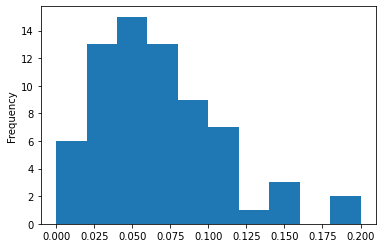

In [366]:
# Frequency of P in NEW_SEQS tail regions
print(df_train_test_new[(df_train_test_new['DATASET'] == 'NEW_SEQS') & (df_train_test_new['LABEL'] == 'T')].P_FREQ.describe())
df_train_test_new[(df_train_test_new['DATASET'] == 'NEW_SEQS') & (df_train_test_new['LABEL'] == 'T')].P_FREQ.plot.hist()

count    59.000000
mean      0.072241
std       0.032990
min       0.017857
25%       0.051109
50%       0.066176
75%       0.086164
max       0.202128
Name: P_FREQ, dtype: float64


<AxesSubplot: ylabel='Frequency'>

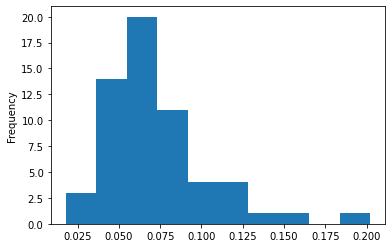

In [368]:
# Frequency of P in TRAIN and TEST sequences tail regions
print(df_train_test_new[(df_train_test_new['DATASET'] != 'NEW_SEQS') & (df_train_test_new['LABEL'] == 'T')].P_FREQ.describe())
df_train_test_new[(df_train_test_new['DATASET'] != 'NEW_SEQS') & (df_train_test_new['LABEL'] == 'T')].P_FREQ.plot.hist()